In [1]:
import pickle
import pandas as pd
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import metrics
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, roc_curve
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

In [2]:
data = pd.read_csv("heart_dataset_1.csv")

split_data = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=32)
for train_index, test_index in split_data.split(data, data['target']):
    train_set = data.loc[train_index]
    test_set = data.loc[test_index]

#splitting for train set data
Ftrs_train = train_set.drop(columns='target', axis=1)
Trgt_train = train_set['target']

#splitting for test set data
Ftrs_test = test_set.drop(columns='target', axis=1)
Trgt_test = test_set['target']

##### BEST PERFORMING MODELS (Top 5):

``` 
Rank       Name                       Variable Name
----------------------------------------------------
1.    Gaussian Naive Bayes             model_gnb
2.    Support Vector Machine           model_svm
3.    Random Forest                    model_rfc
4.    Logistic Regression              model_logreg
5.    MLP Neural Network               model_mlp 
```

In [3]:
model_gnb=pickle.load(open('trained_gnb.sav', 'rb'))
model_svm=pickle.load(open('trained_svm.sav', 'rb'))
model_rfc=pickle.load(open('trained_rfc.sav', 'rb'))
model_log=pickle.load(open('trained_logreg.sav','rb'))
model_mlp=pickle.load(open('trained_mlp.sav','rb'))

d:\games\pydownload\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator GaussianNB from version 1.3.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\games\pydownload\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator SVC from version 1.3.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
d:\games\pydownload\lib\site-packages\sklearn\base.py:299: UserWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.2.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please re

### Confidence Scores for the models

In [4]:
cs_gnb=model_gnb.predict_proba(Ftrs_test)
cs_svm=model_svm.predict_proba(Ftrs_test)
cs_rfc=model_rfc.predict_proba(Ftrs_test)
cs_log=model_log.predict_proba(Ftrs_test)
cs_mlp=model_mlp.predict_proba(Ftrs_test)

### Applying Sugeno Fuzzy Integral based Ensemble Method

In [5]:
def find_max(arr):
    class_0=arr[0]
    class_1=arr[1]

    if class_0>class_1:
        return 0
    elif class_0<class_1:
        return 1
    else:
        return 1

In [6]:
from sympy.solvers import solve
from sympy import Symbol
def sugeno(solution,pred1,pred2,pred3, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) - (l+1), l )
    if len(lam) < 3:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,3):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [7]:
acc, ypred, cs_sugeno = sugeno([0.6,0.6,0.2], cs_gnb, cs_svm, cs_rfc, Trgt_test)

In [8]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.91      0.88      0.89        82
           1       0.90      0.93      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184

Accuracy Score:  0.907608695652174
ROC-AUC Score:  0.9047106647537063
PR-AUC Score:  0.9370889660211911


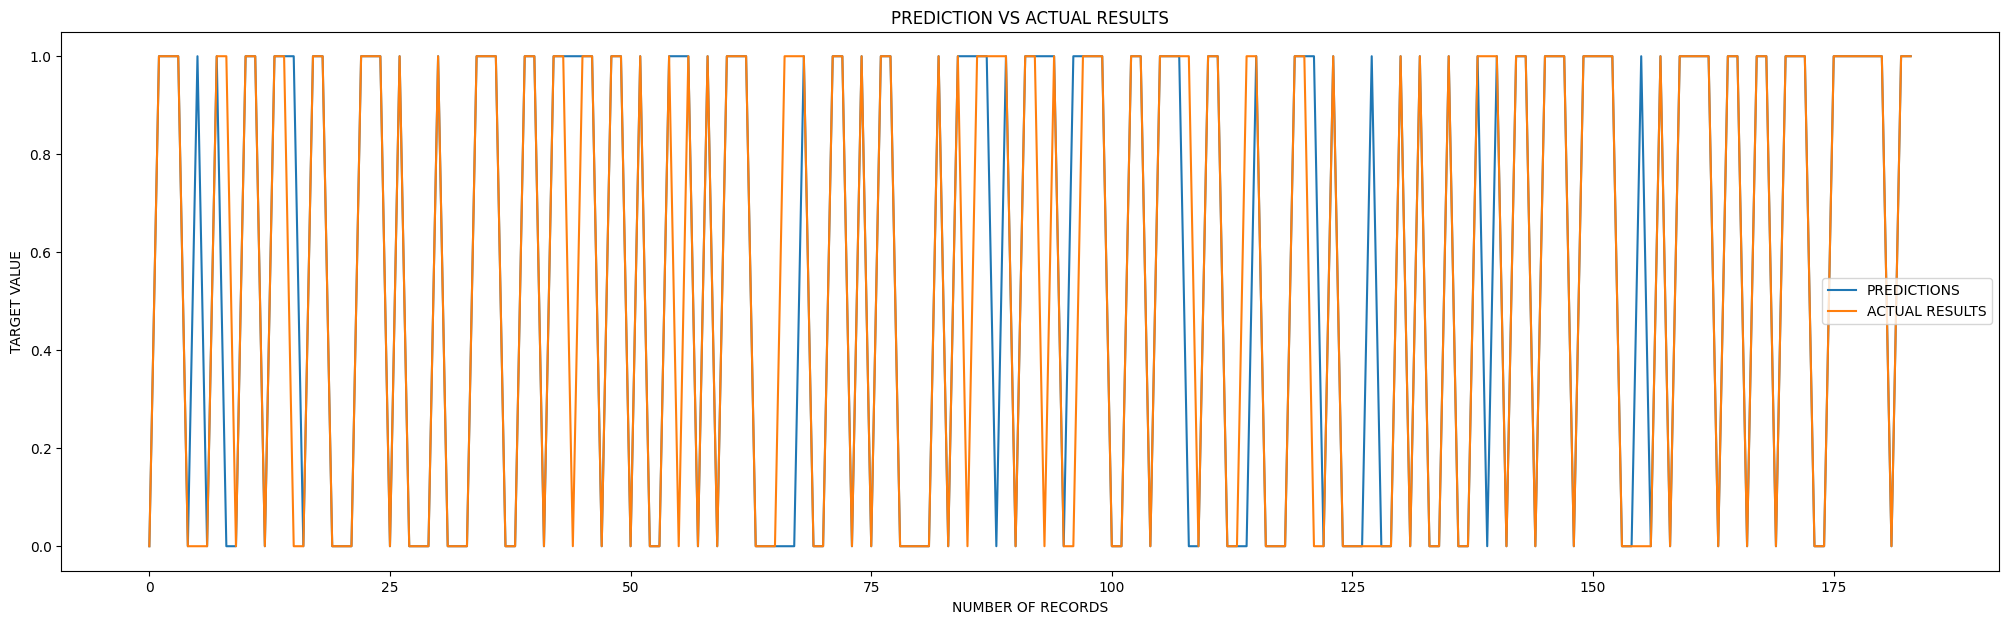

In [9]:
fig = plt.figure(figsize=(25, 7))
plt.plot(ypred,label="PREDICTIONS")
plt.xlabel("NUMBER OF RECORDS")
plt.ylabel("TARGET VALUE")
test_result=np.array(Trgt_test)
plt.plot(test_result,label="ACTUAL RESULTS")
plt.title("PREDICTION VS ACTUAL RESULTS")
plt.legend()

# sfi(class 4)

In [10]:
def sugeno(solution,pred1,pred2,pred3,pred4, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2],solution[3]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) *( 1 + l* fuzzymeasures[3]) - (l+1), l )
    if len(lam) < 4:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
      elif lam[3] >= 0:
          lam = np.asarray(lam[3])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes],pred4[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,4):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                # except ValueError:
                #     sl=scoreslambda.all()
                #fuzzyprediction = max((fuzzyprediction,min((sl,ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [11]:
# s=1
# l=0
# v,m,l2=0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 try:             
#                     acc, ypred,label= sugeno([z,jj,k,gg],cs_mlp, cs_svm,cs_gnb,cs_rfc,Trgt_test)
#                     print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                     print()
#                     if acc>0.907608695652174:
#                         print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         l=jj
#                         m=k
#                         v=z
#                         l2=gg
#                 except ValueError:
#                     pass
            
                
# print("done")
# print(v,l,m,l2)

optimized measures:

in the order: mlp,svm,gnb,rfc

0.4     0.3     0.1     0.2
0.1 	 0.2 	 0.4 	 0.3

0.2 	 0.1 	 0.3 	 0.4
 0.2 	 0.3 	 0.3 	 0.2

  0.2 	 0.4 	 0.3 	 0.1
  0.3 	 0.1 	 0.2 	 0.4

  0.3 	 0.2 	 0.2 	 0.3
  0.3 	 0.4 	 0.2 	 0.1
  0.4 	 0.1 	 0.1 	 0.4
  0.4 	 0.2 	 0.1 	 0.3
   0.4 	 0.3 	 0.1 	 0.2

In [12]:
acc, ypred,label= sugeno([0.4, 0.3, 0.1, 0.2],cs_mlp, cs_svm,cs_gnb,cs_rfc,Trgt_test)
acc

0.9130434782608695

In [13]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        82
           1       0.93      0.91      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.91      0.91       184
weighted avg       0.91      0.91      0.91       184

Accuracy Score:  0.9130434782608695
ROC-AUC Score:  0.9131994261119082
PR-AUC Score:  0.945338874680307


# sfi(class 5)

In [14]:
def sugeno(solution,pred1,pred2,pred3,pred4,pred5, labels):
    fuzzymeasures = np.array([solution[0],solution[1],solution[2],solution[3],solution[4]])
    l = Symbol('l', real = True)
    lam = solve(  ( 1 + l* fuzzymeasures[0]) * ( 1 + l* fuzzymeasures[1]) *( 1 + l* fuzzymeasures[2]) *( 1 + l* fuzzymeasures[3]) *( 1 + l* fuzzymeasures[4]) - (l+1), l )
    if len(lam) < 5:
      lam = np.asarray(lam)
    else:
      if lam[0] >= 0:
          lam = np.asarray(lam[0])
      elif lam[1] >= 0:
          lam = np.asarray(lam[1])
      elif lam[2] >= 0:
          lam = np.asarray(lam[2])
      elif lam[3] >= 0:
          lam = np.asarray(lam[3])
      elif lam[4] >= 0:
          lam = np.asarray(lam[4])
    
    Ypred_fuzzy = np.zeros(shape = pred1.shape, dtype = float)
    for sample in range(0,pred1.shape[0]):
        for classes in range(0,2):
            scores = np.array([pred1[sample][classes],pred2[sample][classes],pred3[sample][classes],pred4[sample][classes],pred5[sample][classes]])
            permutedidx = np.flip(np.argsort(scores))
            scoreslambda = scores[permutedidx]
            fmlambda = fuzzymeasures[permutedidx]
            ge_prev = fmlambda[0]
            fuzzyprediction = min((scoreslambda[0], fmlambda[0]))
            for i in range(1,5):
                ge_curr = ge_prev + fmlambda[i] + lam * fmlambda[i] * ge_prev
                fuzzyprediction = max((fuzzyprediction,min((scoreslambda[i],ge_curr))))
                # except ValueError:
                #     sl=scoreslambda.all()
                #fuzzyprediction = max((fuzzyprediction,min((sl,ge_curr))))
                ge_prev = ge_curr

            Ypred_fuzzy[sample][classes] = fuzzyprediction
            


    
    ypred_fuzzy = np.argmax(Ypred_fuzzy, axis=1)
    pred_label = []
    for i in ypred_fuzzy:
      label = np.zeros((2))
      label[i] = label[i]+1
      pred_label.append(label)
    pred_label = np.array(pred_label)
    

    sugeno_predict=[]
    for i in range(len(pred_label)):
        arr=[]
        arr=pred_label[i]
        ans=find_max(arr)
        sugeno_predict.append(ans)
        
    
    
    acc = accuracy_score(labels,sugeno_predict)
    return acc,ypred_fuzzy,pred_label

In [15]:
# s=1
# l=0
# v,m,l2,l3=0,0,0,0
# for x in range(1,11):
#     z=x/10
#     for i in range(1,11):
#         jj=i/10
#         for f in range(1,11):
#             k=f/10
#             for g in range(1,11):
#                 gg=g/10
#                 for p in range(1,11):
#                     pp=p/10
#                     try:             
#                         acc, ypred,label= sugeno([z,jj,k,gg,pp],cs_mlp, cs_svm,cs_gnb,cs_rfc,cs_log,Trgt_test)
#                         print("\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                         print()
#                         if acc>0.9130434782608695:
#                             print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                             l=jj
#                             m=k
#                             v=z
#                             l2=gg
#                         elif acc>=0.907608695652174:
#                             print("improoved: ","\t",acc,"\t",z,"\t",jj,"\t",k,"\t",gg)
#                             l=jj
#                             m=k
#                             v=z
#                             l2=gg
#                     except ValueError:
#                         pass
            
                
# print("done")
# print(v,l,m,l2,l3)

0.1 	 1.0 	 0.4 	 1.0
0.1 	 0.9 	 0.1 	 0.9
0.1 	 0.9 	 0.4 	 0.9
0.4 	 0.9 	 0.1 	 0.9
0.4 	 1.0 	 0.1 	 1.0

In [16]:
# for p in range(1,11):
#     pp=p/10;
#     try:
#         acc, ypred,label= sugeno([0.4,1.0,0.1,1.0,pp],cs_mlp, cs_svm,cs_gnb,cs_rfc,cs_log,Trgt_test)
#         print(acc,"\t",pp)
#         print()
#         if acc>=0.907608695652174:
#             print("improoved/tie: ","\t",acc,"\t",pp)
#     except ValueError:
#         pass

# print("done")

In [20]:
acc, ypred,label= sugeno([0.4,1.0,0.1,1.0,0.1],cs_mlp, cs_svm,cs_gnb,cs_rfc,cs_log,Trgt_test)
acc

0.907608695652174

In [21]:
print("Classification Report")
print(classification_report(Trgt_test,ypred))

print("Accuracy Score: ", acc)

print("ROC-AUC Score: ",roc_auc_score(Trgt_test, ypred))

precision, recall, thresholds = metrics.precision_recall_curve(Trgt_test, ypred)
auc = metrics.auc(recall, precision)
print("PR-AUC Score: ", auc)

Classification Report
              precision    recall  f1-score   support

           0       0.92      0.87      0.89        82
           1       0.90      0.94      0.92       102

    accuracy                           0.91       184
   macro avg       0.91      0.90      0.91       184
weighted avg       0.91      0.91      0.91       184

Accuracy Score:  0.907608695652174
ROC-AUC Score:  0.9035150645624103
PR-AUC Score:  0.9354907139613262


mlp,
svm,
gnb,
rfc